# Run NetConf on Houston IEEE data

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [2]:
#[None, './data/Houston/Hyperspectral/20170218_UH_CASI_S4_NAD83.pix',None,'./data/Houston/LiDAR/UH17_GI3F051.tif', None,'./data/Houston/HighResolution/houstonmosaic.tif'],
                  

# Data files
labelFile = './data/Houston/GroundTruth/2018_IEEE_GRSS_DFC_GT_TR.tif' # Ground Truth
hsFile = './data/Houston/Hyperspectral/20170218_UH_CASI_S4_NAD83.pix' # Hyperspectral file
radarFile = './data/Houston/LiDAR/UH17_GI3F051.tif' # LiDAR file
skip = 10 # Downsample by using every nth sample
crs = 'EPSG:6577' # Coordinate system

# A priori class beliefs
nClasses, cn = 2, 'class' # Number of classes (Houston default: 20), name of classes
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Pre-processing 
pca, comp  = False, 4 # Hyperspectral data PCA, component number
cluster = 'mean' # Clustering type if nClasses < nLabels ('all' samples used or 'mean' of label class used)

# Edge creation
adjacent, geoNeighbours, phase, neighbours = True, 0, True, [0,7,0] # geographical edges, n neighbours, data value edges, n neighbours for each data type

In [3]:
#img = ro.open('./data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif')
# #img.read()
# bds = img.bounds
# #ro.transform.from_bounds(bds[0],bds[1],bds[2],bds[3],img.read().shape[2],img.read().shape[1])#, width, height)
# #img.read().shape
# y = np.linspace(bds[0],bds[2],img.read().shape[1])
# x = np.linspace(bds[1],bds[3],img.read().shape[2])

In [4]:
%cd ../

/home/jovyan/damage-assessment


In [5]:
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
import numpy as np

import ground_truth


def get_training_array(tif):
    array = tif.read(window=from_bounds(*ground_truth.data.labelled_bounds + (tif.transform,)),
                     out_shape=(tif.count, ground_truth.data.height, ground_truth.data.width),
                     resampling=Resampling.bilinear)
    return normalise(array, tif.nodata)


def normalise(array, nodata):
    """Sets pixels with nodata value to zero then normalises each channel to between 0 and 1"""
    array[array == nodata] = 0
    return (array - array.min(axis=(1, 2))[:, None, None]) / (
        (array.max(axis=(1, 2)) - array.min(axis=(1, 2)))[:, None, None])

def read_tif_channels(tif, channel_index):
    if not isinstance(channel_index, list):
        channel_index = list(channel_index)
    if channel_index[0] == 0: # rasterio indexes channels starting from 1 not 0...
        channel_index = list(np.array(channel_index) + 1)
    profile = tif.profile
    profile.update({'count': len(channel_index)})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(tif.read(channel_index))
    return memory_file


def resample_tif(tif, scale_factor, mode=Resampling.bilinear):
    data = tif.read(
        out_shape=(
            tif.count,
            int(tif.height * scale_factor),
            int(tif.width * scale_factor)
        ),
        resampling=mode
    )
    # scale image transform
    transform = tif.transform * tif.transform.scale(
        (tif.width / data.shape[-1]),
        (tif.height / data.shape[-2])
    )
    profile = tif.profile
    profile.update({'width': int(tif.width * scale_factor),
                    'height': int(tif.height * scale_factor),
                    'transform': transform})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(data)
    return memory_file

import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from glob import glob
import ground_truth

def mosaic(directory):
    file_paths = glob(directory + "/*.tif")
    tif_list = []
    for path in file_paths:
        tif = rasterio.open(path)
        tif_list.append(resample_tif(tif, tif.transform[0] / ground_truth.data.resolution))
    mosaic_tif, mosaic_transform = merge(tif_list)
    profile = tif_list[0].profile
    profile.update({'width': mosaic_tif.shape[-1],
                    'height': mosaic_tif.shape[-2],
                    'transform': mosaic_transform})
    memory_file = MemoryFile().open(**profile)
    memory_file.write(mosaic_tif)
    return memory_file


def training_array():
    file_directory = "/data_old/2018IEEE_Contest/Phase2/Final RGB HR Imagery"
    return get_training_array(mosaic(file_directory))

In [6]:
import imageio
imageio.imwrite('test',highresarr)

NameError: name 'highresarr' is not defined

In [27]:
highresarr.shape

(3, 1202, 4768)

In [33]:
import matplotlib.pyplot as plt

imageio.imwrite('houstonmosaic.jpeg',np.dstack((highresarr[0],highresarr[1],highresarr[2])))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [6]:
import numpy as np
import imageio
highresarr = np.array(imageio.imread('./data/Houston/HighResolution/houstonmosaic.tif'))

In [9]:
highresarr.shape

(1202, 4768, 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


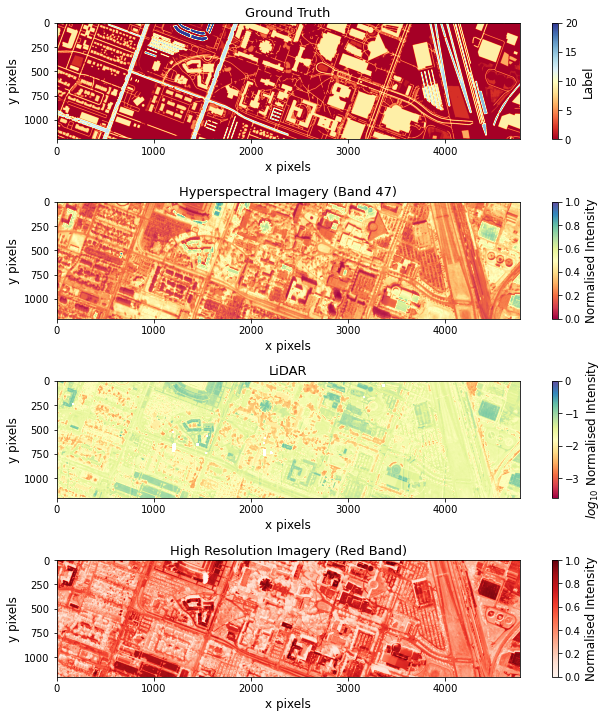

In [12]:
#Import ground truth
# labels, larr = ip.raster_to_df(labelFile)

# # Import aerial data
# hs, hsarr = ip.raster_to_df(hsFile, value='amp', multidims=True, crop=True)
# radar, radararr = ip.raster_to_df(radarFile, value='phase', crop=True)
# processed = False

# High Res import
# a = training_array()
# highresarr = a.copy()
# import pandas as pd
# highres = pd.DataFrame(highresarr.reshape(-1,len(highresarr)),columns=['R','G','B'])
# highres['x'], highres['y'] = np.tile(np.arange(highresarr.shape[2]),highresarr.shape[1]), np.repeat(range(highresarr.shape[1]),highresarr.shape[2])
# highres = highres.set_index(['y','x'])

import numpy as np
# Plot rasters for each data type
fig, axs = pl.create_subplots(4,1,[10,10])
a = axs[0].imshow(larr[0],cmap='RdYlBu')
axs[0].set_title('Ground Truth',fontsize=13)
axs[0].set_xlabel('x pixels',fontsize=12)
axs[0].set_ylabel('y pixels',fontsize=12)
ac = fig.colorbar(a,ax=axs[0])
ac.set_label('Label',fontsize=12)
b = axs[1].imshow(hsarr[47],cmap='Spectral')
axs[1].set_title('Hyperspectral Imagery (Band 47)',size=13)
axs[1].set_xlabel('x pixels',fontsize=12)
axs[1].set_ylabel('y pixels',fontsize=12)
bc = fig.colorbar(b,ax=axs[1])
bc.set_label('Normalised Intensity',fontsize=12)
c = axs[2].imshow(np.log10(radararr[0]),cmap='Spectral')
axs[2].set_title('LiDAR',size=13)
axs[2].set_xlabel('x pixels',fontsize=12)
axs[2].set_ylabel('y pixels',fontsize=12)
cc = fig.colorbar(c,ax=axs[2])
cc.set_label('$log_{10}$ Normalised Intensity',fontsize=12)
d = axs[3].imshow(highresarr[:,:,0],cmap='Reds')
axs[3].set_title('High Resolution Imagery (Red Band)',size=13)
axs[3].set_xlabel('x pixels',fontsize=12)
axs[3].set_ylabel('y pixels',fontsize=12)
dd = fig.colorbar(d,ax=axs[3])
dd.set_label('Normalised Intensity',fontsize=12)
fig.tight_layout()

In [13]:
fig.savefig('results/houstonDataSources')

In [5]:
# Pre-process data
rm = labels[cn] != 0 # Remove unclassified data
labelsp, hsp, radarp, highresp = labels[rm][::skip], hs[rm][::skip], radar[rm][::skip], highres[rm][::skip] # Downsample data to run BP

# K-Means Clustering if nClasses < nLabels
if nClasses < len(labels[cn].unique()):
    # Run PCA on hyperspectral data
    X = hf.run_PCA(hsp.values.transpose(), comp).components_.transpose() if pca else radarp
    # Clustering
    kmeans, clusterClasses,_ = hf.run_cluster(X, labelsp, cluster, nClasses)
    print(clusterClasses)
else: clusterClasses = hf.default_classes(labelsp[cn])

[0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]


In [12]:
# Filter values for hyperspectral classes
takeClasses = False
if takeClasses: 
    classesUsed, labelsCl, hsCl, radarCl, highresCl = [], labelsp, hsp, radarp, highresp
    for j in range(nClasses): classesUsed.append([i+1 for i, x in enumerate(list(clusterClasses)) if x==j])
else:
    classesUsed = [[3,20],[6,15]]
#    classesUsed = [[1,2,3,4,5,6,7],[8,9,10,11,12,13,14,15,16,17,18,19,20]]
#    classesUsed = [[1,2,3,4,5,6,8,10,12,14,15,16,18],[11,20],[7,9,13,17,19]]
    used = [i in [3,20,6,15] for i in labelsp.values]
#    used = [i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] for i in labelsp.values]
    labelsCl, hsCl, radarCl, highresCl = labelsp[used], hsp[used], radarp[used], highresp[used]

# Get geodatabase of every pixel and assign beliefs
initial = hf.init_beliefs(hf.concat_dfs([hsCl,radarCl, highresCl]), classes=nClasses, crs=crs)
#initial = hf.init_beliefs(radarCl, classes=nClasses, crs=crs)

# Assign labels for each pixel
geoLabels = hf.df_to_gdf(labelsCl, columns=[cn], crs=crs, reIndex=True)
geoLabels[cn] = hf.group_classes(geoLabels[cn], classesUsed)
labelSummary = geoLabels.groupby('class').size()
equivUse = False
if equivUse:
    equiv = gpd.GeoDataFrame()
    for i in labelSummary.index.values:
        equiv = equiv.append(geoLabels[geoLabels['class'] == i][0:min(labelSummary)])
    
    # Split pixels in to train and test sets    
    X_train, X_test, y_train, y_test = hf.train_test_split(equiv, column = cn)
else: X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = cn)

# Create nodes for belief propagation from pixels, assigning priors to train set
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses-1:-1], beliefs=confidence)

# Create edges dependent on geographical and/or hyperspectral and lidar proximity
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbours=geoNeighbours, values=[nodes.columns[:50], ['phase'], ['R','G','B']] if phase else False, neighbours=neighbours)
# #edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=[['phase']] if phase else False, neighbours=neighbours)

In [13]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 7582, Edges: 53074
It	Loss	Label change

0	6.32866e-01		4623

1	2.70984e-01		42

2	1.31265e-01		3

3	6.24455e-02		0

4	2.96878e-02		1

5	1.40678e-02		0

6	6.65840e-03		1

7	3.14765e-03		0

8	1.48697e-03		0

9	7.02010e-04		0

Time elapsed: 6.849219083786011 seconds


              precision    recall  f1-score   support

         0.0       0.91      0.81      0.85       904
         1.0       0.88      0.95      0.91      1371

    accuracy                           0.89      2275
   macro avg       0.89      0.88      0.88      2275
weighted avg       0.89      0.89      0.89      2275



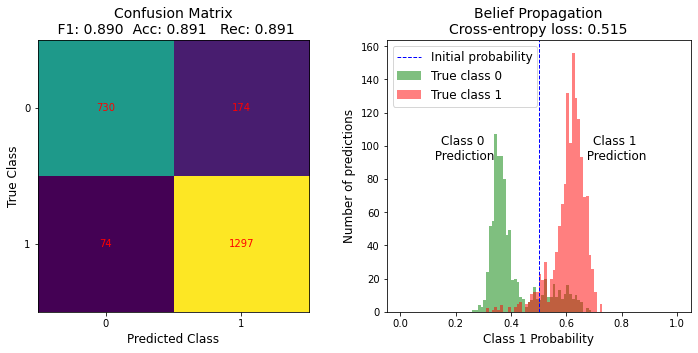

In [14]:
import numpy as np
classes =  np.array(range(nClasses))

# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
true_clf, pred_clf = hf.class_metrics(y_true, y_pred, classes, classes)


# Visualisations
fig, axs = pl.create_subplots(1,2, figsize=[12,5])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, pred_clf, classes)

# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], true_clf, y_pred, classes)
pl.show_plot()


# pred_clf, true_clf = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=unique)

# fig, axs = pl.create_subplots(1,2, figsize=[14,5])

# # Confusion matrix
# axs = pl.confusion_matrix(axs, pred_clf, true_clf, usedNames)

# # Cross entropy / Confidence metrics
# if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), usedNames)
# else: axs[1] = pl.cross_entropy_multiclass(axs[1], true_clf, y_pred, usedNames)

In [15]:
# Save figure
writeOut = classesUsed if takeClasses is False else []
pl.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}_cl{}{}{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(takeClasses),str(nClasses),str(writeOut)))#,str(pca),str(comp),cluster))

17


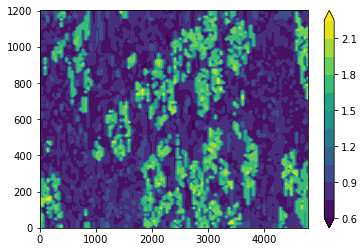

In [103]:
from scipy.interpolate import griddata
import math
import matplotlib.pyplot as plt
ngrid=100
xi, yi = np.linspace(nodes.geometry.x.min(), nodes.geometry.x.max(), ngrid), np.linspace(nodes.geometry.y.min(), nodes.geometry.y.max(), ngrid)
zi = griddata((nodes.geometry.x, nodes.geometry.y), (beliefs[:,0]-beliefs[:,1]+0.5), (xi[None, :], yi[:, None]), method='nearest')
#cs = plt.contourf(xi, yi, zi, norm=matplotlib.colors.Normalize(vmin=zi.min(), vmax=zi.max()),levels=20)
levs = math.floor((zi.max()-zi.min())/0.1)
print(levs)
cs = plt.contourf(xi, yi, zi, levels=levs-1, extend='both')
plt.colorbar()

In [28]:
initial.groupby('label').count()

,0,1,2,3,4,5,6,7,8,9,...,48,49,phase,R,G,B,cl0,cl1,cl2,geometry
label,,,,,,,,,,,,,,,,,,,,,
1,182,182,182,182,182,182,182,182,182,182,...,182,182,182,182,182,182,182,182,182,182
2,637,637,637,637,637,637,637,637,637,637,...,637,637,637,637,637,637,637,637,637,637
3,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
4,273,273,273,273,273,273,273,273,273,273,...,273,273,273,273,273,273,273,273,273,273
5,112,112,112,112,112,112,112,112,112,112,...,112,112,112,112,112,112,112,112,112,112
6,82,82,82,82,82,82,82,82,82,82,...,82,82,82,82,82,82,82,82,82,82
7,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
8,796,796,796,796,796,796,796,796,796,796,...,796,796,796,796,796,796,796,796,796,796
9,4514,4514,4514,4514,4514,4514,4514,4514,4514,4514,...,4514,4514,4514,4514,4514,4514,4514,4514,4514,4514


In [26]:
len(pred_clf)

606

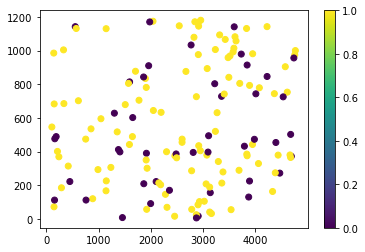

In [41]:

plt.colorbar()


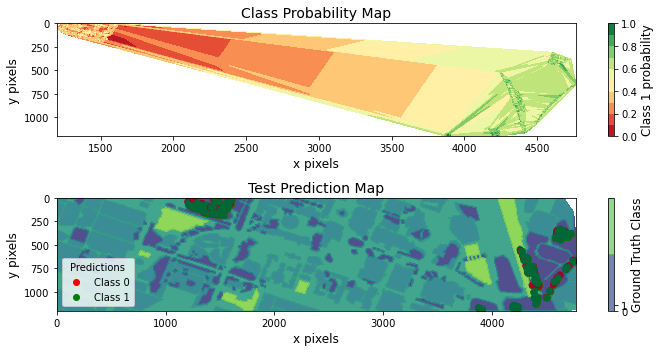

In [11]:
conv = labelsp.reset_index(level=['x', 'y'])
conv['class']=hf.group_classes(labelsp['class'], classesUsed)
fig, [ax1,ax2] = pl.create_subplots(2,1,[10,5])
normalized = (beliefs[:,1]-min(beliefs[:,1]))/(max(beliefs[:,1])-min(beliefs[:,1]))
res = ax1.tricontourf(nodes.geometry.x,nodes.geometry.y,normalized,cmap='RdYlGn',levels=10)
cb1 = fig.colorbar(res,ax=ax1)
cb1.set_label('Class 1 probability',fontsize=12), ax1.set_title('Class Probability Map',size=14)
ax1.invert_yaxis()
ax1.set_xlabel('x pixels', fontsize=12), ax1.set_ylabel('y pixels',fontsize=12)
ax2.set_xlabel('x pixels', fontsize=12), ax2.set_ylabel('y pixels',fontsize=12)
# ax1.axes.get_xaxis().set_visible(False)
# ax1.axes.get_yaxis().set_visible(False)
ax2.invert_yaxis()
alt =conv['class'].values
# for i, val in enumerate(alt): 
#     print(val)
#     if val == 1: alt[i]=val-0.001
a = ax2.tricontourf(conv.dropna().x,conv.dropna().y, alt,alpha=0.7,levels=1)
a2 = ax2.tricontourf(conv.dropna().x,conv.dropna().y, alt,alpha=0.7,levels=2)

ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c='r',label='Class 0')
ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c='g',label='Class 1')
ax2.scatter(X_test[::10].geometry.x,X_test[::10].geometry.y,c=pred_clf[::10],cmap='RdYlGn')
cb2 = fig.colorbar(a, ax=ax2, ticks=[0,1])
cb2.set_label('Ground Truth Class',fontsize=12), ax2.set_title('Test Prediction Map',size=14)
ax2.legend(title='Predictions',loc='lower left')
fig.tight_layout()

In [135]:
fig.savefig('results/plotDemo.png')

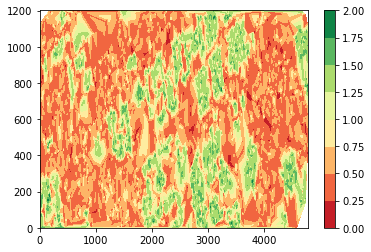

In [99]:
plt.tricontourf(nodes.geometry.x,nodes.geometry.y,beliefs[:,0],cmap='RdYlGn')
plt.colorbar()

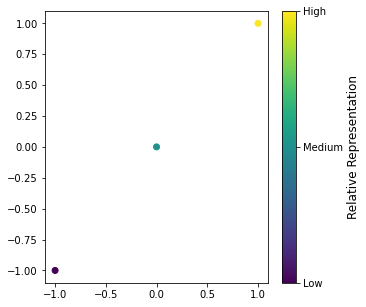

In [194]:
import matplotlib.pyplot as plt
a, ax = plt.subplots(1,1,figsize=[5,5])
b = ax.scatter([-1,0,1],[-1,0,1],c=[-1,0,1])
cbar = plt.colorbar(b,ticks=[-1, 0, 1])
cbar.set_label('Relative Representation',fontsize=12)
cbar.set_ticklabels(['Low', 'Medium', 'High'])
plt.show()
a.savefig('results/confusionColorbar.png')

# 